In [1]:
import numpy as np
from __future__ import print_function
import time, os, json
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.utils import to_categorical
import utilities
import random
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
data = np.genfromtxt("keras_RNN_D9A87.csv", delimiter=',', skip_header=1, names=['epoch','acc','loss','val_acc','val_loss'])

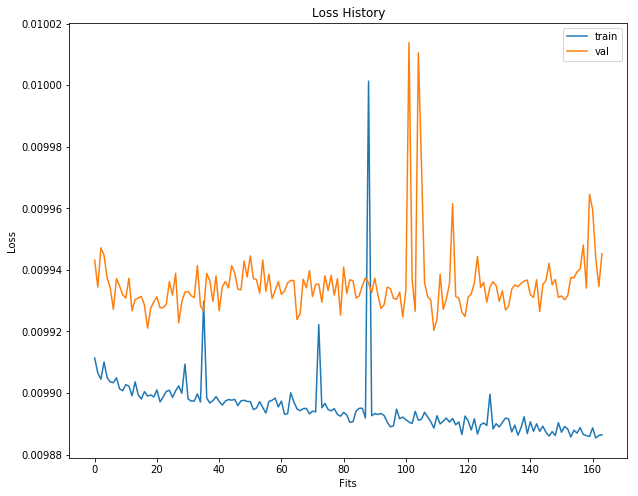

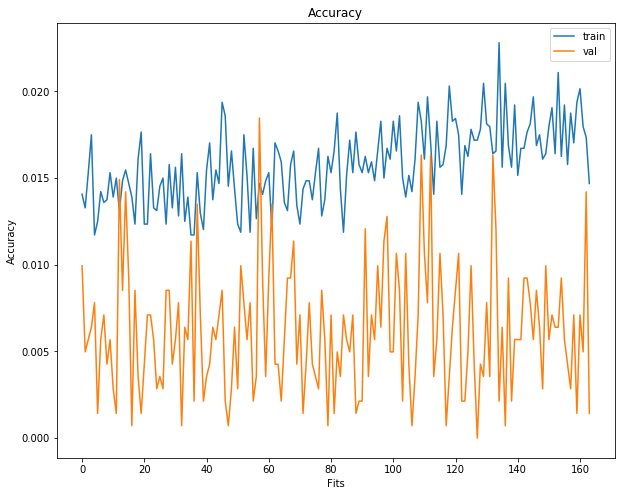

In [3]:
plt.plot(data['loss'],label="train")
plt.plot(data['val_loss'], label="val")
plt.title("Loss History")
plt.xlabel("Fits")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(data['acc'],label="train")
plt.plot(data['val_acc'], label="val")
plt.title("Accuracy")
plt.xlabel("Fits")
plt.ylabel("Accuracy")
plt.legend()

In [4]:
# load data
mypath = "/home/Chelsea/tmp_cropped"
img_files = [os.path.join(mypath, f) for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath, f)))]
x_data, flows_data, y_data_orig = utilities.load_data(img_files)
# x_data is: [imu_data, v, d_raw[i_start:i_end,1:4]
imu_data = x_data[:,0:6]
y_data = np.reshape(y_data_orig, (y_data_orig.shape[0],1) )

cats, mean = utilities.discretize_outputs(y_data, 100) # 100 bins
cats = np.reshape(cats, (cats.shape[0],1))
print(cats.shape)
print(mean.shape)
y_data = cats
y_data = to_categorical(y_data)
print(y_data.shape)

print("flows_data.shape",flows_data.shape)
print("imu_data.shape", imu_data.shape)
print("y_data.shape", y_data.shape)
N_flows,H,W,C = flows_data.shape
N_imu, imu_H = imu_data.shape
N_y, y_h = y_data.shape

N_training = int(0.7*flows_data.shape[0])
N_validation = int(0.5*(flows_data.shape[0]- N_training))
N_test = flows_data.shape[0] - N_training - N_validation
print("N train:", N_training)
print("N val:", N_validation)
print("N test:", N_test)

Loading vector data
Loading image data
Preprocessing data
(9400, 1)
(100,)
(9400, 100)
flows_data.shape (9400, 48, 64, 2)
imu_data.shape (9400, 6)
y_data.shape (9400, 100)
N train: 6580
N val: 1410
N test: 1410


In [5]:
# load pretrained model and model weights from checkpoint file
# define model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import concatenate
from keras import losses
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

minibatch_dim = 32
sequence_length = 10 # really the sliding window backprop length. 
n_windows = 6

# placeholder for images
img_inputs = Input(batch_shape=(minibatch_dim,sequence_length,H,W,C)) # truly: (minibatch_dim, seq_len, H, W, C)
# process images
interm = TimeDistributed(Conv2D(64, 3, strides=2, padding='valid', data_format="channels_last", activation='relu'))(img_inputs)
#interm = TimeDistributed(MaxPooling2D(pool_size=(1,3), strides=(1,2), padding = 'valid'))(interm)
extracted_image_features =  TimeDistributed(Flatten())(interm)
# placeholder for imu data
imu_inputs = Input(batch_shape=(minibatch_dim,sequence_length, imu_H))
# process imu data
extracted_imu_features = TimeDistributed(Dense(32, activation='relu'))(imu_inputs)

# concat together
top_out = concatenate([extracted_image_features, extracted_imu_features])

# have data of shape: minibatchsize X seq_length X 22112 after other layers
out1 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(top_out)
out2 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(out1)
out3 = LSTM(512,activation='elu', unroll=True)(out2)
out4 = Dense(100)(out3)


# define model
model = Model(inputs=[img_inputs, imu_inputs], outputs=out4)

# LOAD THOSE WEIGHTS BABY
model.load_weights("weights.best.hdf5")

from keras.optimizers import Adam
optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

In [7]:
# do predictions
start_ind = 0
sequence_length = 10
batch_size = 32
raw_predicts = np.zeros((N_flows, 100)) # class scores for 100 classes
while start_ind + batch_size < N_flows:
    x_img_batch, x_imu_batch = utilities.sample_sequential_batch(batch_size, sequence_length, flows_data, imu_data, start_ind=start_ind)
    raw_predicts[start_ind:start_ind+batch_size, :] = model.predict([x_img_batch, x_imu_batch], verbose=2, batch_size=batch_size)
    start_ind += batch_size

In [8]:
class_predicts = np.argmax(raw_predicts, axis=-1)
err_predicts = mean[class_predicts]
err_predicts.shape

(9400,)

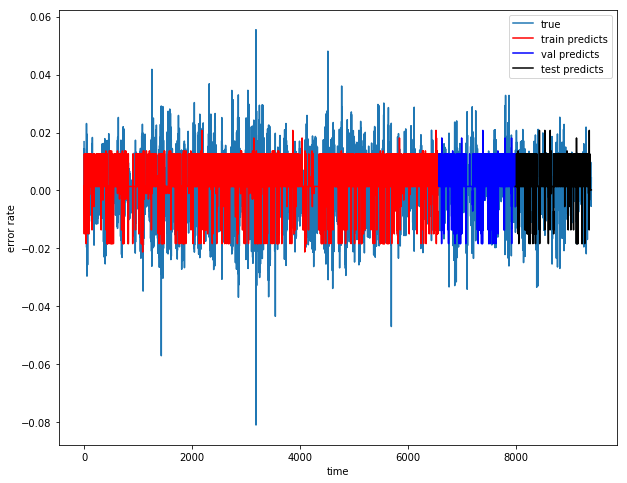

In [9]:
plt.figure()
plt.plot(y_data_orig, label="true")
plt.plot(range(0,N_training),err_predicts[0:N_training], label="train predicts", color="red")
plt.plot(range(N_training,N_training+N_validation),err_predicts[N_training:N_training+N_validation], label="val predicts", color="blue")
plt.plot(range(N_training+N_validation,N_flows),err_predicts[N_training+N_validation:], label="test predicts", color="black")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

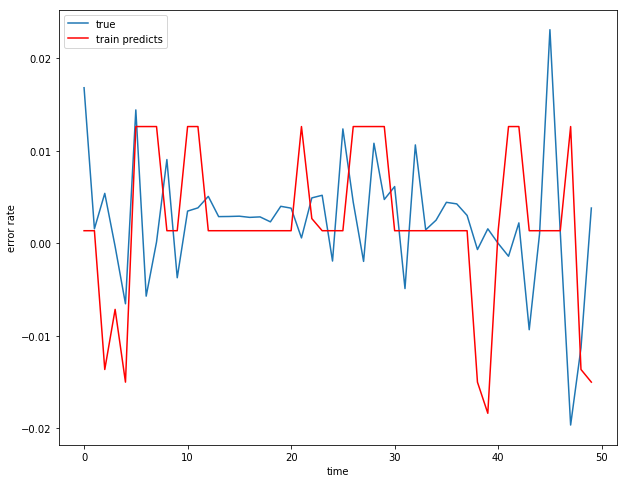

In [10]:
# unsmoothed
plt.figure()
plt.plot(y_data_orig[0:50], label="true")
plt.plot(range(0,N_training)[0:50],err_predicts[0:N_training][0:50], label="train predicts", color="red")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

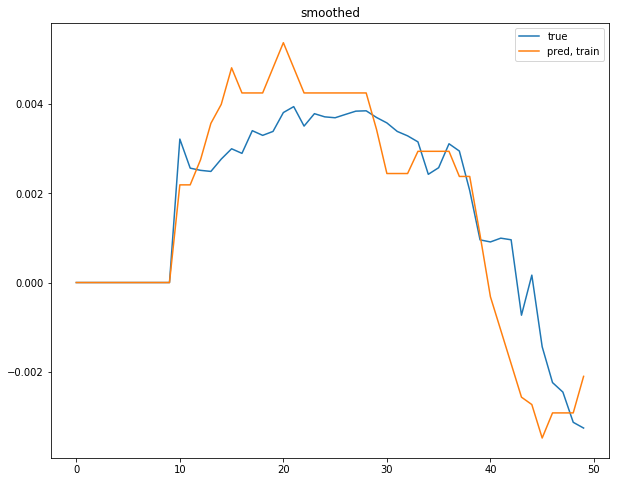

In [11]:
# try smoothing everything
y_smooth = np.zeros(y_data_orig.shape)
y_smooth_pred = np.zeros(err_predicts.shape)
fil_hw = 10
for j in range(fil_hw,len(y_data_orig)-fil_hw):
    y_smooth[j] = np.mean(y_data_orig[j-fil_hw:j+fil_hw])
    y_smooth_pred[j] = np.mean(err_predicts[j-fil_hw:j+fil_hw])

plt.figure()
plt.plot(y_smooth[0:50], label="true")
plt.title("smoothed")
plt.plot(y_smooth_pred[0:50],label="pred, train")
plt.legend()

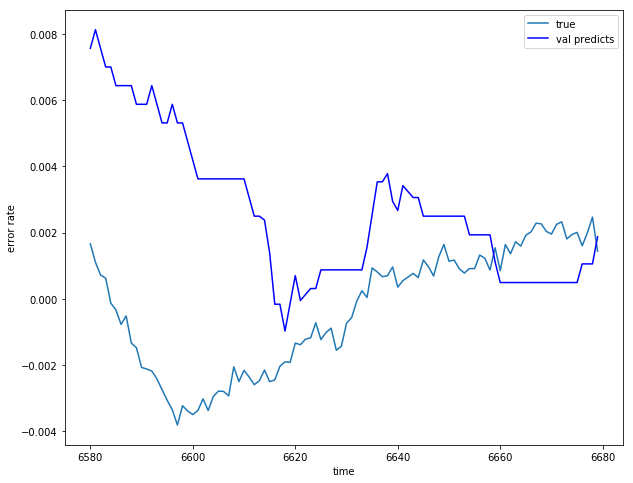

In [12]:
plt.figure()
plt.plot(range(N_training,N_training+N_validation)[0:100],y_smooth[N_training:N_training+N_validation][0:100], label="true")
plt.plot(range(N_training,N_training+N_validation)[0:100],y_smooth_pred[N_training:N_training+N_validation][0:100], label="val predicts", color="blue")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

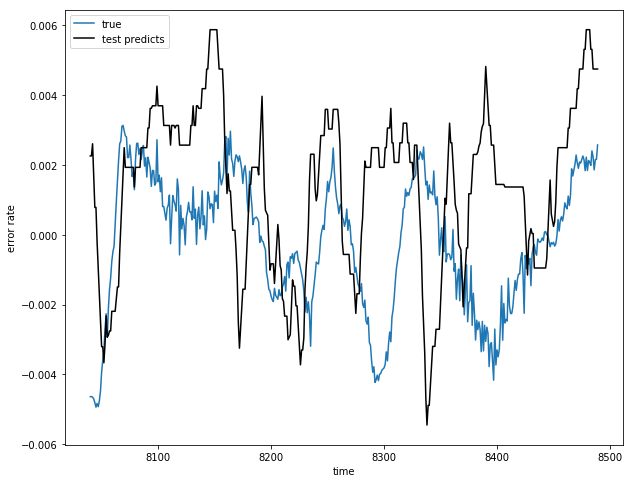

In [13]:
plt.figure()
plt.plot(range(N_training+N_validation,N_flows)[50:500], y_smooth[N_training+N_validation:N_flows][50:500], label="true")
plt.plot(range(N_training+N_validation,N_flows)[50:500],y_smooth_pred[N_training+N_validation:][50:500], label="test predicts", color="black")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.757988591494


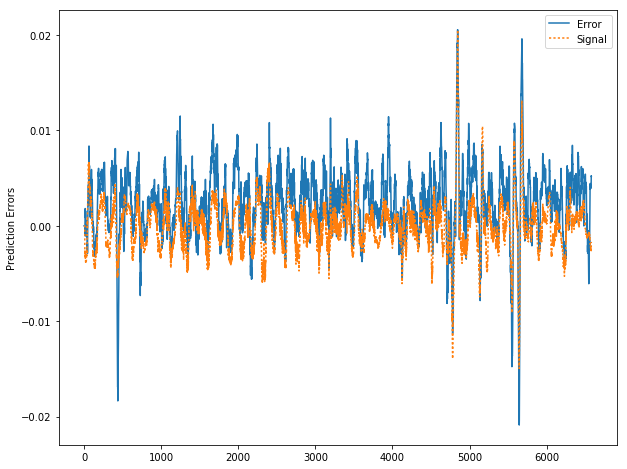

-0.75798859149445841

In [14]:
utilities.plot_error(0, N_training, y_smooth_pred, y_smooth, train_end=None)

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.49222660426


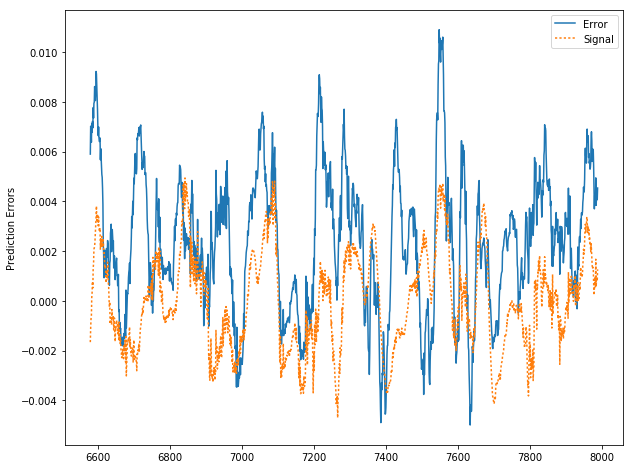

-0.49222660425992915

In [15]:
utilities.plot_error(N_training, N_training+N_validation, y_smooth_pred, y_smooth, train_end=None)

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.614847173213


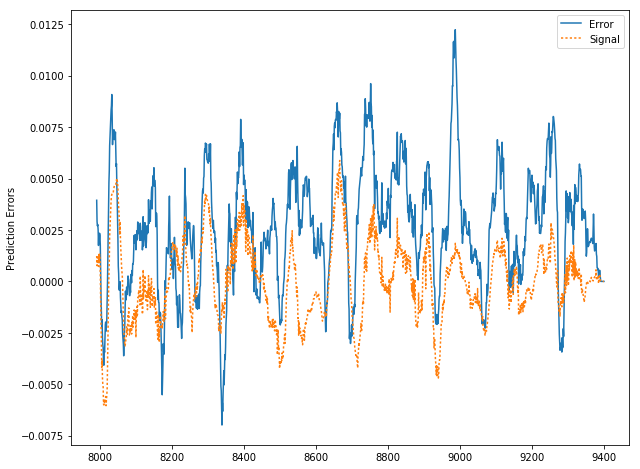

-0.61484717321256599

In [16]:
utilities.plot_error(N_training+N_validation, N_flows, y_smooth_pred, y_smooth, train_end=None)

plotting from  0  to  6580
High correlation (near 1) means we are predicting well.
Correlation between data and signal: 0.00742833938603


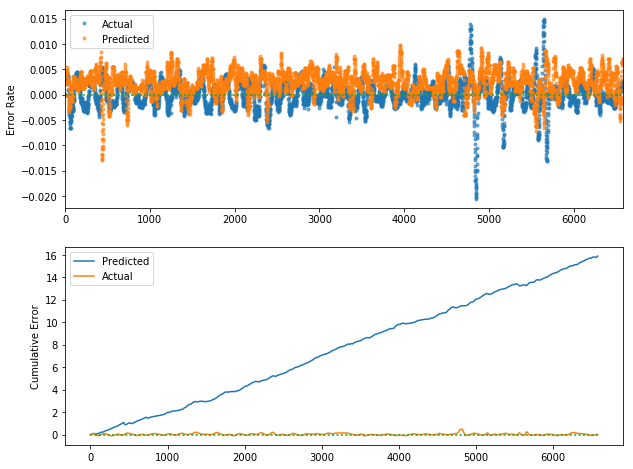

0.0074283393860296839

In [62]:
#plot_data(ns, ne, pred, actual, train_end=None, save=False)
utilities.plot_data(0, N_training, y_smooth_pred, y_smooth, train_end=None)

plotting from  6580  to  7990
High correlation (near 1) means we are predicting well.
Correlation between data and signal: 0.230637401128


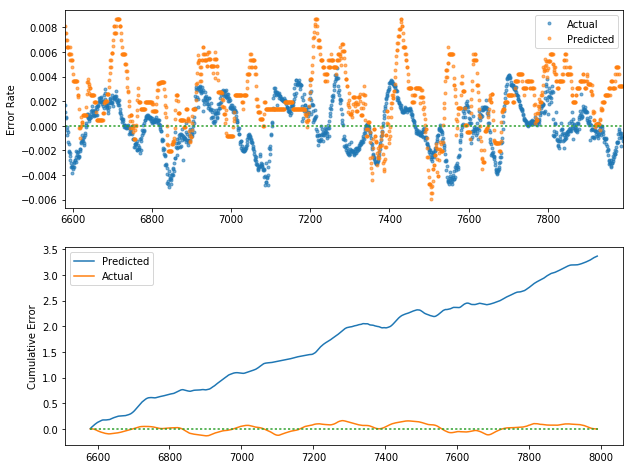

0.230637401128238

In [63]:
utilities.plot_data(N_training, N_training+N_validation, y_smooth_pred, y_smooth, train_end=None)

plotting from  7990  to  9400
High correlation (near 1) means we are predicting well.
Correlation between data and signal: 0.052394807632


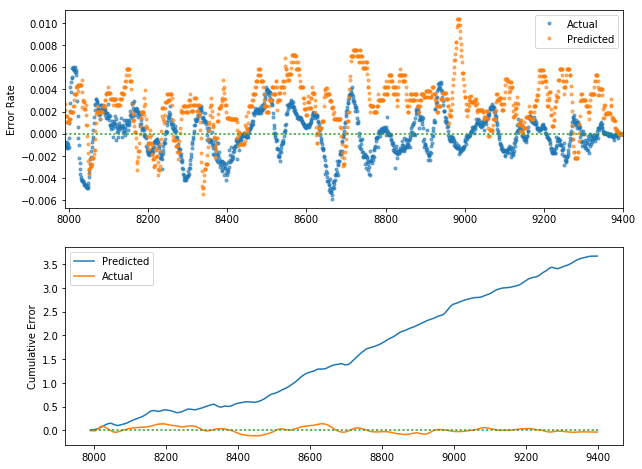

0.052394807631990226

In [64]:
utilities.plot_data(N_training+N_validation, N_flows, y_smooth_pred, y_smooth, train_end=None)

plotting from  0  to  9400
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.0286748656619


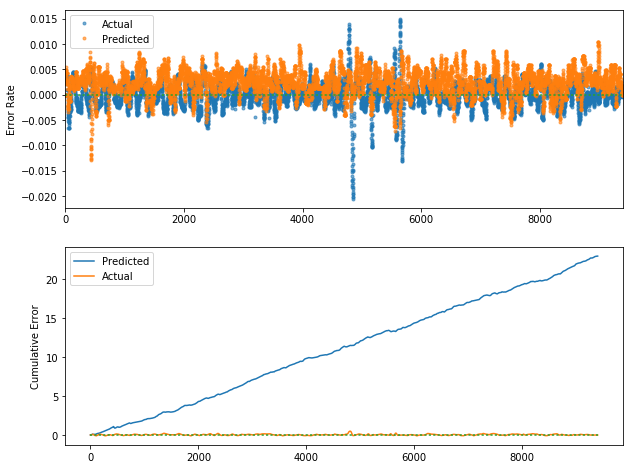

0.028674865661914829

In [61]:
utilities.plot_data(0, N_flows, y_smooth_pred, y_smooth, train_end=None)

In [26]:
# train
train_rmse = utilities.calc_rmse(y_smooth_pred[0:N_training], y_smooth[0:N_training])
print("Training RMSE is ", train_rmse)
train_rel_rmse = utilities.calc_rmse(y_smooth_pred[0:N_training],  y_smooth[0:N_training])/utilities.calc_rmse( y_smooth[0:N_training], np.zeros_like( y_smooth[0:N_training]))
print('Ratio to zero-prediction: ', train_rel_rmse)

Training RMSE is  0.00434217753579
Ratio to zero-prediction:  1.59602770342


In [27]:
# val
val_rmse = utilities.calc_rmse(y_smooth_pred[N_training:N_training+N_validation], y_smooth[N_training:N_training+N_validation])
print("Val RMSE is ", val_rmse)
val_rel_rmse = utilities.calc_rmse(y_smooth_pred[N_training:N_training+N_validation],  y_smooth[N_training:N_training+N_validation])/utilities.calc_rmse( y_smooth[N_training:N_training+N_validation], np.zeros_like( y_smooth[N_training:N_training+N_validation]))
print('Ratio to zero-prediction: ', val_rel_rmse)

Val RMSE is  0.00368475494726
Ratio to zero-prediction:  1.87947792353


In [28]:
# test
test_rmse = utilities.calc_rmse(y_smooth_pred[N_training+N_validation:], y_smooth[N_training+N_validation:])
print("Test RMSE is ", test_rmse)
val_rel_rmse = utilities.calc_rmse(y_smooth_pred[N_training+N_validation:],  y_smooth[N_training+N_validation:])/utilities.calc_rmse( y_smooth[N_training+N_validation:], np.zeros_like( y_smooth[N_training+N_validation:]))
print('Ratio to zero-prediction: ', val_rel_rmse)

Test RMSE is  0.00391933598753
Ratio to zero-prediction:  2.05123256407


In [30]:
# overall
overall_rmse = utilities.calc_rmse(y_smooth_pred, y_smooth)
overall_rel_rmse = utilities.calc_rmse(y_smooth_pred,  y_smooth)/utilities.calc_rmse( y_smooth, np.zeros_like( y_smooth))
print("Overall RMSE is ", overall_rmse)
print('Overall Ratio to zero-prediction: ', overall_rel_rmse)

Overall RMSE is  0.00418795249105
Overall Ratio to zero-prediction:  1.66780575337


In [39]:
# final val accuracy compute during training
print("Final val acc from training: ", data['val_acc'][-1])

Final val acc from training:  0.00142045454545


In [58]:
# accuracy over all portions
train_acc = np.mean((class_predicts[0:N_training] - cats[0:N_training][:,0])==0)
val_acc = np.mean((class_predicts[N_training:N_training+N_validation] - cats[N_training:N_training+N_validation][:,0])==0)
test_acc = np.mean((class_predicts[N_training+N_validation:] - cats[N_training+N_validation:][:,0])==0)
print("train acc:", train_acc)
print("val acc:", val_acc)
print("test acc: ", test_acc)

# calculate within-one accuracy
wo_train_acc = np.mean(abs(class_predicts[0:N_training] - cats[0:N_training][:,0])<=1)
wo_val_acc = np.mean(abs(class_predicts[N_training:N_training+N_validation] - cats[N_training:N_training+N_validation][:,0])<=1)
wo_test_acc = np.mean(abs(class_predicts[N_training+N_validation:] - cats[N_training+N_validation:][:,0])<=1)
print("within one train acc:", wo_train_acc)
print("within one val acc:", wo_val_acc)
print("within one test acc: ", wo_test_acc) 

train acc: 0.00942249240122
val acc: 0.0120567375887
test acc:  0.0127659574468
within one train acc: 0.0276595744681
within one val acc: 0.0382978723404
within one test acc:  0.031914893617


In [54]:
abs(class_predicts[0:5] - cats[0:5][:,0])<=2

array([False,  True, False, False, False], dtype=bool)

In [52]:
cats[0:5][:,0]

array([ 96.,  61.,  81.,  46.,  15.])

In [43]:
acc = np.mean((class_predicts - cats)==0)
acc

0.01